In [1]:
# 🏙️ Day 14: Airbnb NYC Dataset
# Author: David Caleb Chaparro Orozco
# Topic: Exploratory Data Analysis of Airbnb Listings in New York City

# Import necessary libraries
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import zipfile
import os
import warnings
import folium
import scipy.stats as stats
from scipy.stats import ttest_ind, chi2_contingency, norm, f_oneway

# Post-hoc analysis: which borough pairs differ significantly?
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

warnings.filterwarnings('ignore')

# Set style for plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

# Create directories if they don't exist
os.makedirs("outputs", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [2]:
# Download the dataset (returns the local path where files are stored)
path = kagglehub.dataset_download("vrindakallu/new-york-dataset")

print("Files:", os.listdir(path))  

# If the dataset contains a zip file, extract it
zip_path = os.path.join(path, "new_york_listings_2024.csv.zip")
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(path)

# Now read the CSV (adjust filename if different after unzip)
csv_path = os.path.join(path, "new_york_listings_2024.csv")
data = pd.read_csv(
    csv_path,
    encoding="utf-8",
    engine="python",
    on_bad_lines="skip"
)

data.head()


Files: ['new_york_listings_2024.csv']


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,1312228,Rental unit in Brooklyn · ★5.0 · 1 bedroom,7130382,Walter,Brooklyn,Clinton Hill,40.683710,-73.964610,Private room,55.0,...,2015-12-20,0.03,1,0,0,No License,5.0,1,1,Not specified
1,45277537,Rental unit in New York · ★4.67 · 2 bedrooms ·...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.766610,-73.988100,Entire home/apt,144.0,...,2023-05-01,0.24,139,364,2,No License,4.67,2,1,1
2,971353993633883038,Rental unit in New York · ★4.17 · 1 bedroom · ...,528871354,Joshua,Manhattan,Chelsea,40.750764,-73.994605,Entire home/apt,187.0,...,2023-12-18,1.67,1,343,6,Exempt,4.17,1,2,1
3,3857863,Rental unit in New York · ★4.64 · 1 bedroom · ...,19902271,John And Catherine,Manhattan,Washington Heights,40.835600,-73.942500,Private room,120.0,...,2023-09-17,1.38,2,363,12,No License,4.64,1,1,1
4,40896611,Condo in New York · ★4.91 · Studio · 1 bed · 1...,61391963,Stay With Vibe,Manhattan,Murray Hill,40.751120,-73.978600,Entire home/apt,85.0,...,2023-12-03,0.24,133,335,3,No License,4.91,Studio,1,1


In [3]:
# Check a overview of the dataset
def overview(data):
    print("=".center(50,"="))

    # Print the shape of the dataset to see how many rows and columns it has.
    print(f"\nAirbnb NYC Overview")
    print(f"Shape: {data.shape}")
    print(f"Memory Usage: {data.memory_usage().sum()/1024/1024:.2f} MB")
    print("=".center(50,"="))

    # Display Index, Columns, and Data Types
    print("Information about the features:")
    print(data.info())
    print("=".center(50,"="))
    dtype_counts = data.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"{str(dtype):<20}: {count} columns")
    print("=".center(50,"="))

    # Display summary statistics
    print("Basic statistics check:")
    print(data.describe())
    print("=".center(50,"="))

    # I always run this part to understand the unique values in each column.
    # It helps me get a sense of the data, especially which features are categorical or have low variability.
    print("Checking the number of unique values:")
    unique_counts = {}
    for column in data.columns:
        unique_counts[column] = data[column].nunique()
    unique_data = pd.DataFrame(unique_counts, index=["Unique Count"]).transpose()
    print(unique_data)
    print("=".center(50, "="))
overview(data)


Airbnb NYC Overview
Shape: (20758, 22)
Memory Usage: 3.48 MB
Information about the features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   name                            20758 non-null  object 
 2   host_id                         20758 non-null  int64  
 3   host_name                       20758 non-null  object 
 4   neighbourhood_group             20758 non-null  object 
 5   neighbourhood                   20758 non-null  object 
 6   latitude                        20758 non-null  float64
 7   longitude                       20758 non-null  float64
 8   room_type                       20758 non-null  object 
 9   price                           20758 non-null  float64
 10  minimum_nights                  20758 non-null  int64  
 11 

## Data Cleaning

In [4]:
print("=".center(50, "="))
print("Data Cleaning Phase")
print("=".center(50, "="))

# Check for duplicates
print(f"Initial shape: {data.shape}")
duplicate_rows = data.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows}")

# Remove duplicates if any
if duplicate_rows > 0:
    data = data.drop_duplicates()
    print(f"Shape after removing duplicates: {data.shape}")

# Check for missing values
print("\nMissing values analysis:")
missing_values = data.isnull().sum()
missing_pct = (missing_values / len(data)) * 100
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_pct.round(2)
})
print(missing_data[missing_data['Missing Values'] > 0])

# Handle specific missing values in baths column
print("\nBefore cleaning - Baths value counts:")
print(data['baths'].value_counts().head())

# Convert baths to numeric, handling 'Not specified' and other non-numeric values
data['baths_clean'] = data['baths'].apply(lambda x: np.nan if x == 'Not specified' else pd.to_numeric(x, errors='coerce'))

print("After cleaning - Baths value counts:")
print(data['baths_clean'].value_counts().sort_index().head(10))

# Handle bedrooms column (contains mixed types)
print("\nBefore cleaning - Bedrooms value counts:")
print(data['bedrooms'].value_counts())

# Convert bedrooms to numeric, handling non-numeric values
data['bedrooms_clean'] = pd.to_numeric(data['bedrooms'], errors='coerce')

# For 'Studio' values, set bedrooms to 0
studio_mask = data['bedrooms'].astype(str).str.lower() == 'studio'
data.loc[studio_mask, 'bedrooms_clean'] = 0

print("After cleaning - Bedrooms value counts:")
print(data['bedrooms_clean'].value_counts().sort_index())

# Handle rating column (convert to numeric)
data['rating_clean'] = pd.to_numeric(data['rating'], errors='coerce')

# Handle price outliers (cap at 99th percentile)
price_99 = data['price'].quantile(0.99)
print(f"\n99th percentile of price: ${price_99:.2f}")
data['price_capped'] = data['price'].clip(upper=price_99)

Data Cleaning Phase
Initial shape: (20758, 22)
Duplicate rows: 0

Missing values analysis:
Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []

Before cleaning - Baths value counts:
baths
1      17015
2       2082
1.5     1001
2.5      240
3        171
Name: count, dtype: int64
After cleaning - Baths value counts:
baths_clean
0.0       82
1.0    17015
1.5     1001
2.0     2082
2.5      240
3.0      171
3.5       50
4.0       69
4.5       18
5.0        6
Name: count, dtype: int64

Before cleaning - Bedrooms value counts:
bedrooms
1         13439
2          3602
Studio     1815
3          1394
4           345
5           112
6            29
7             9
9             6
8             5
15            1
14            1
Name: count, dtype: int64
After cleaning - Bedrooms value counts:
bedrooms_clean
0.0      1815
1.0     13439
2.0      3602
3.0      1394
4.0       345
5.0       112
6.0        29
7.0         9
8.0         5
9.0         6
14.0        1
15.0        1
Name: co

## EDA (Exploratory Data Analysis)

In [5]:
print("\n" + "="*50)
print("Exploratory Data Analysis")
print("=".center(50, "="))

# Display basic dataset information
print(f"Dataset shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

# Display unique values for categorical columns
print(f"\nNeighbourhood Groups: {data['neighbourhood_group'].unique()}")
print(f"Room types: {data['room_type'].unique()}")

# Basic statistics for numerical columns
print("\nBasic statistics for numerical columns:")
data.describe()


Exploratory Data Analysis
Dataset shape: (20758, 26)
Columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license', 'rating', 'bedrooms', 'beds', 'baths', 'baths_clean', 'bedrooms_clean', 'rating_clean', 'price_capped']

Neighbourhood Groups: ['Brooklyn' 'Manhattan' 'Queens' 'Bronx' 'Staten Island']
Room types: ['Private room' 'Entire home/apt' 'Hotel room' 'Shared room']

Basic statistics for numerical columns:


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,beds,baths_clean,bedrooms_clean,rating_clean,price_capped
count,2.075800e+04,2.075800e+04,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20745.000000,20758.000000,17006.000000,20758.000000
mean,3.034044e+17,1.749316e+08,40.726798,-73.939161,187.776616,28.558435,42.642596,1.257910,18.844108,205.990317,10.852105,1.723721,1.177995,1.306725,4.734253,168.036805
std,3.901216e+17,1.725541e+08,0.060294,0.061403,1022.797208,33.536518,73.561654,1.904661,70.910834,135.087768,21.357071,1.212272,0.480456,0.877419,0.294387,151.338756
min,2.595000e+03,1.678000e+03,40.500314,-74.249840,10.000000,1.000000,1.000000,0.010000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.750000,10.000000
25%,2.708808e+07,2.041738e+07,40.684150,-73.980710,80.000000,30.000000,4.000000,0.210000,1.000000,87.000000,1.000000,1.000000,1.000000,1.000000,4.640000,80.000000
50%,4.993003e+07,1.087271e+08,40.722820,-73.949587,125.000000,30.000000,14.000000,0.650000,2.000000,215.000000,3.000000,1.000000,1.000000,1.000000,4.810000,125.000000
75%,7.216019e+17,3.144102e+08,40.763098,-73.917460,199.000000,30.000000,49.000000,1.800000,5.000000,353.000000,15.000000,2.000000,1.000000,2.000000,4.930000,199.000000
max,1.054376e+18,5.504035e+08,40.911147,-73.713650,100000.000000,1250.000000,1865.000000,75.490000,713.000000,365.000000,1075.000000,42.000000,15.500000,15.000000,5.000000,999.000000


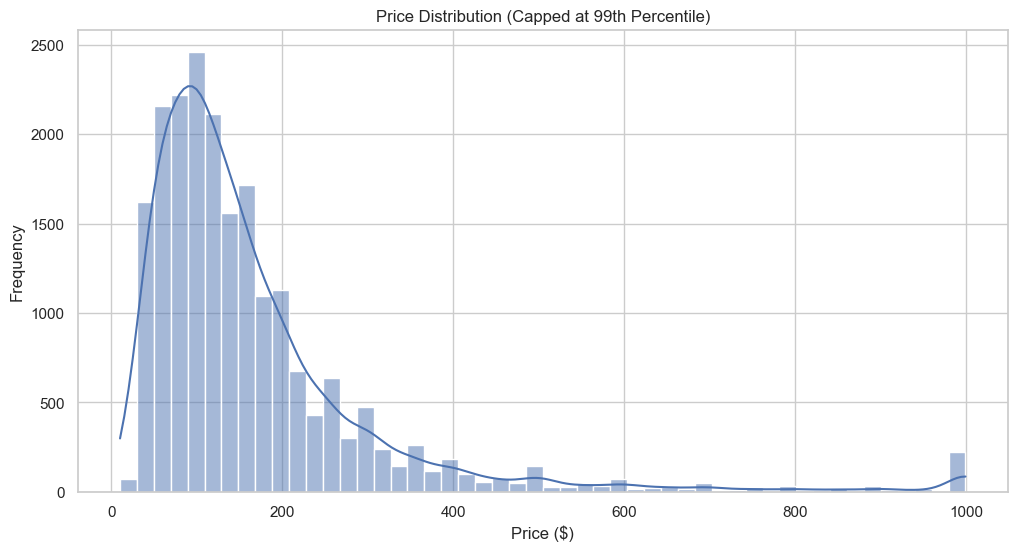

In [6]:
# 1. Price distribution (considering outliers)
plt.figure(figsize=(12, 6))
sns.histplot(data['price_capped'], bins=50, kde=True)
plt.title('Price Distribution (Capped at 99th Percentile)')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.savefig('outputs/price_distribution.png', bbox_inches='tight', dpi=300)
plt.show()

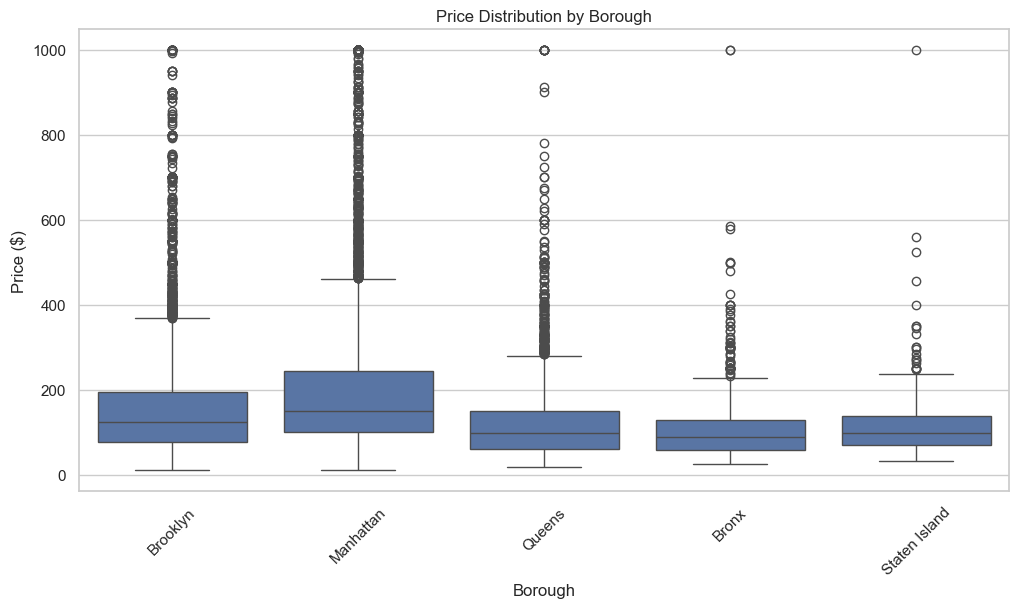

In [7]:
# 2. Price by neighborhood group
plt.figure(figsize=(12, 6))
sns.boxplot(x='neighbourhood_group', y='price_capped', data=data)
plt.title('Price Distribution by Borough')
plt.xlabel('Borough')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.savefig('outputs/price_by_borough.png', bbox_inches='tight', dpi=300)
plt.show()

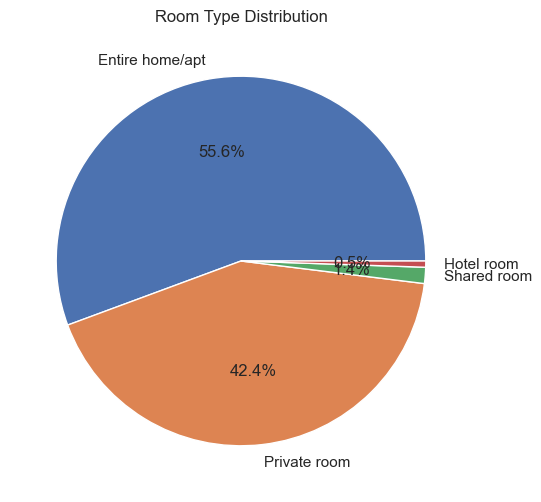

In [8]:
# 3. Room type distribution
plt.figure(figsize=(10, 6))
room_type_counts = data['room_type'].value_counts()
plt.pie(room_type_counts, labels=room_type_counts.index, autopct='%1.1f%%')
plt.title('Room Type Distribution')
plt.savefig('outputs/room_type_distribution.png')
plt.show()

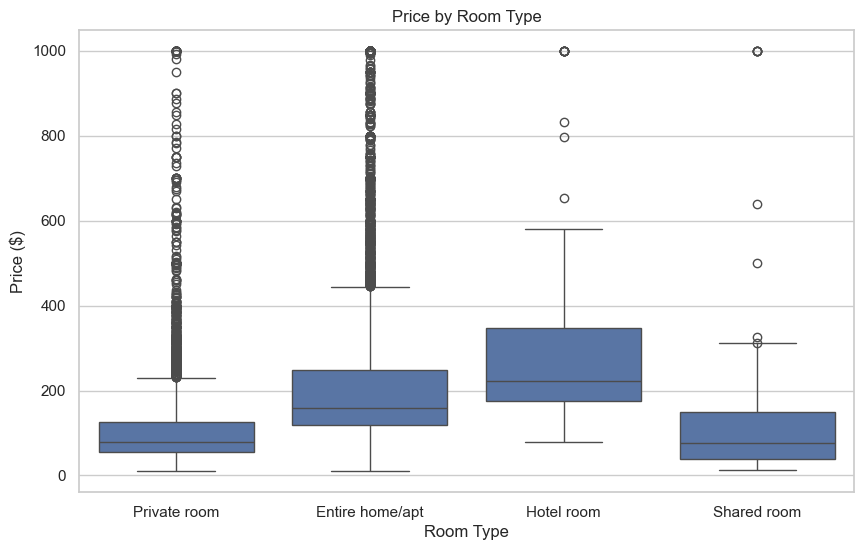

In [9]:
# 4. Price by room type
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price_capped', data=data)
plt.title('Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.savefig('outputs/price_by_room_type.png', bbox_inches='tight', dpi=300)
plt.show()

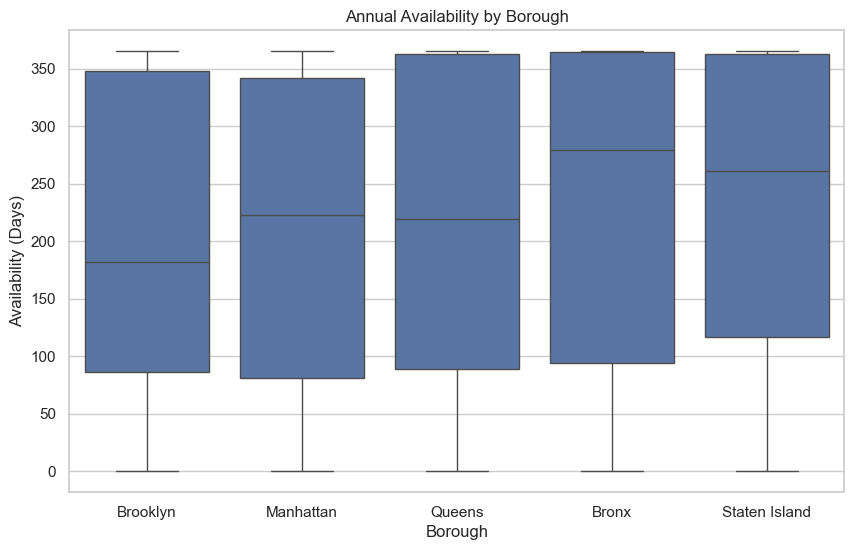

In [10]:
# 5. Availability by borough
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbourhood_group', y='availability_365', data=data)
plt.title('Annual Availability by Borough')
plt.xlabel('Borough')
plt.ylabel('Availability (Days)')
plt.savefig('outputs/availability_by_borough.png', bbox_inches='tight', dpi=300)
plt.show()

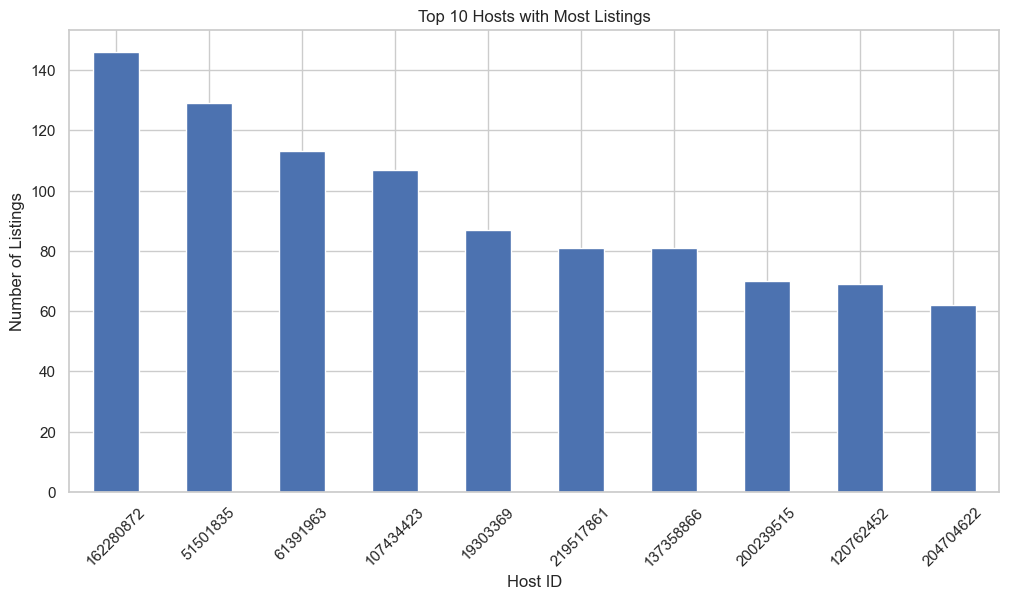

In [11]:
# 6. Top hosts with most listings
top_hosts = data['host_id'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_hosts.plot(kind='bar')
plt.title('Top 10 Hosts with Most Listings')
plt.xlabel('Host ID')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.savefig('outputs/top_hosts.png', bbox_inches='tight', dpi=300)
plt.show()

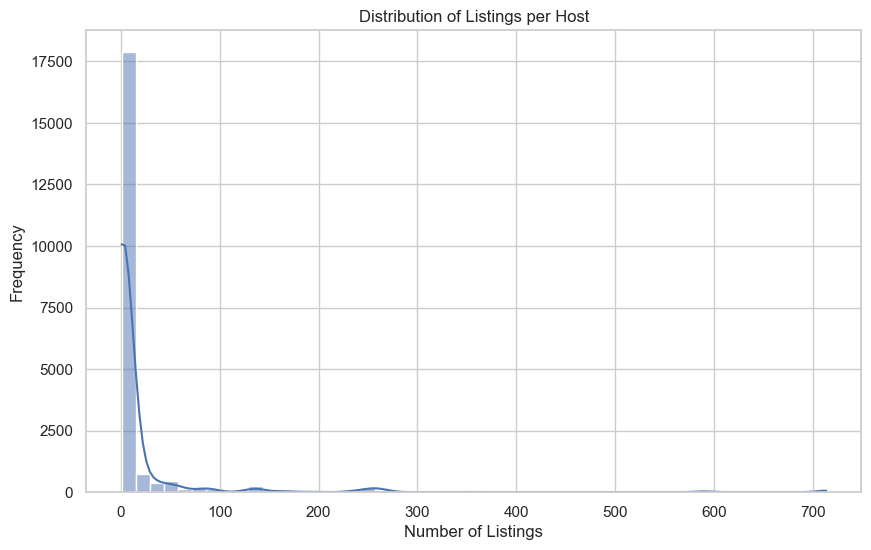

In [12]:
# 7. Listings distribution per host
plt.figure(figsize=(10, 6))
sns.histplot(data['calculated_host_listings_count'], bins=50, kde=True)
plt.title('Distribution of Listings per Host')
plt.xlabel('Number of Listings')
plt.ylabel('Frequency')
plt.savefig('outputs/listings_per_host.png', bbox_inches='tight', dpi=300)
plt.show()

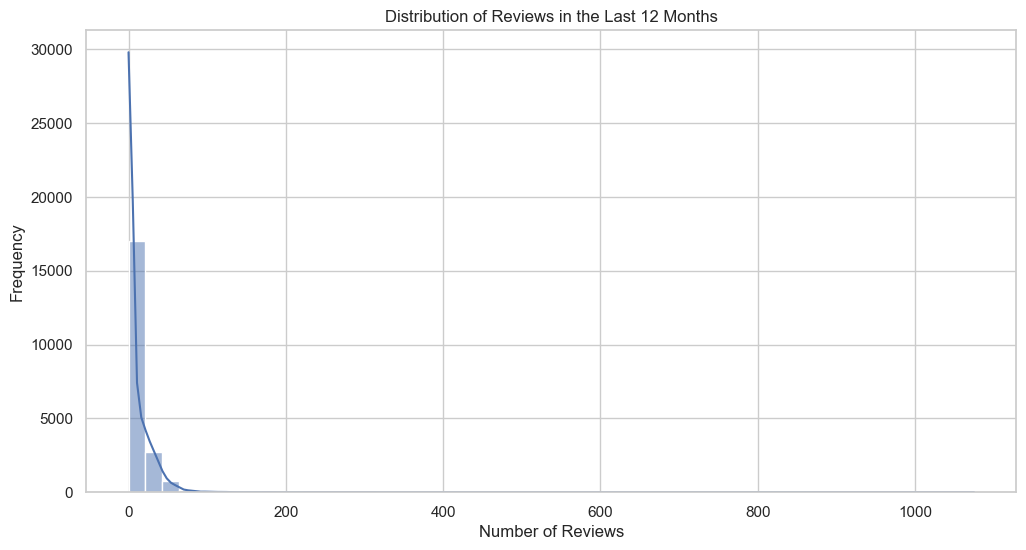

In [13]:
# 8. Reviews in last 12 months
plt.figure(figsize=(12, 6))
sns.histplot(data['number_of_reviews_ltm'], bins=50, kde=True)
plt.title('Distribution of Reviews in the Last 12 Months')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.savefig('outputs/reviews_last_12_months.png', bbox_inches='tight', dpi=300)
plt.show()


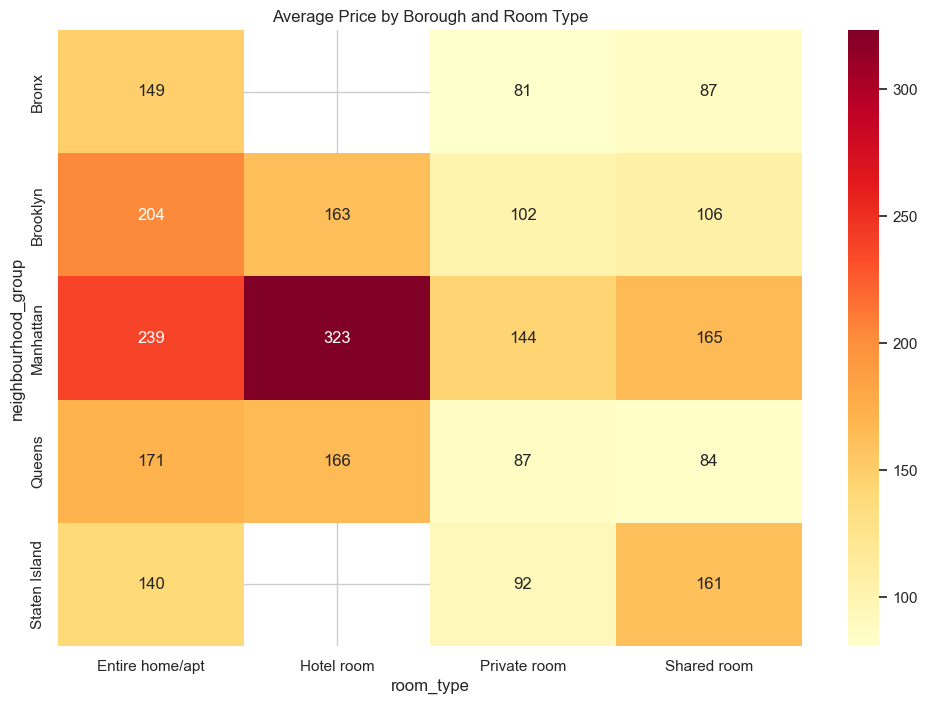

In [14]:
# 9. Price heatmap by borough and room type
pivot_table = pd.pivot_table(data, 
                            values='price_capped', 
                            index='neighbourhood_group', 
                            columns='room_type', 
                            aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Average Price by Borough and Room Type')
plt.savefig('outputs/price_heatmap.png', bbox_inches='tight', dpi=300)
plt.show()

In [15]:
# 10. Geographical distribution of listings
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Color coding by borough
borough_colors = {
    'Manhattan': 'red',
    'Brooklyn': 'blue',
    'Queens': 'green',
    'Bronx': 'purple',
    'Staten Island': 'orange'
}

# Add points to the map

# Show only 1000 points for performance
for idx, row in data.sample(1000).iterrows():  
    borough = row['neighbourhood_group']
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=borough_colors.get(borough, 'gray'),
        fill=True,
        fill_color=borough_colors.get(borough, 'gray'),
        popup=f"{row['name']} - ${row['price']}"
    ).add_to(nyc_map)

nyc_map.save('outputs/nyc_airbnb_map.html')

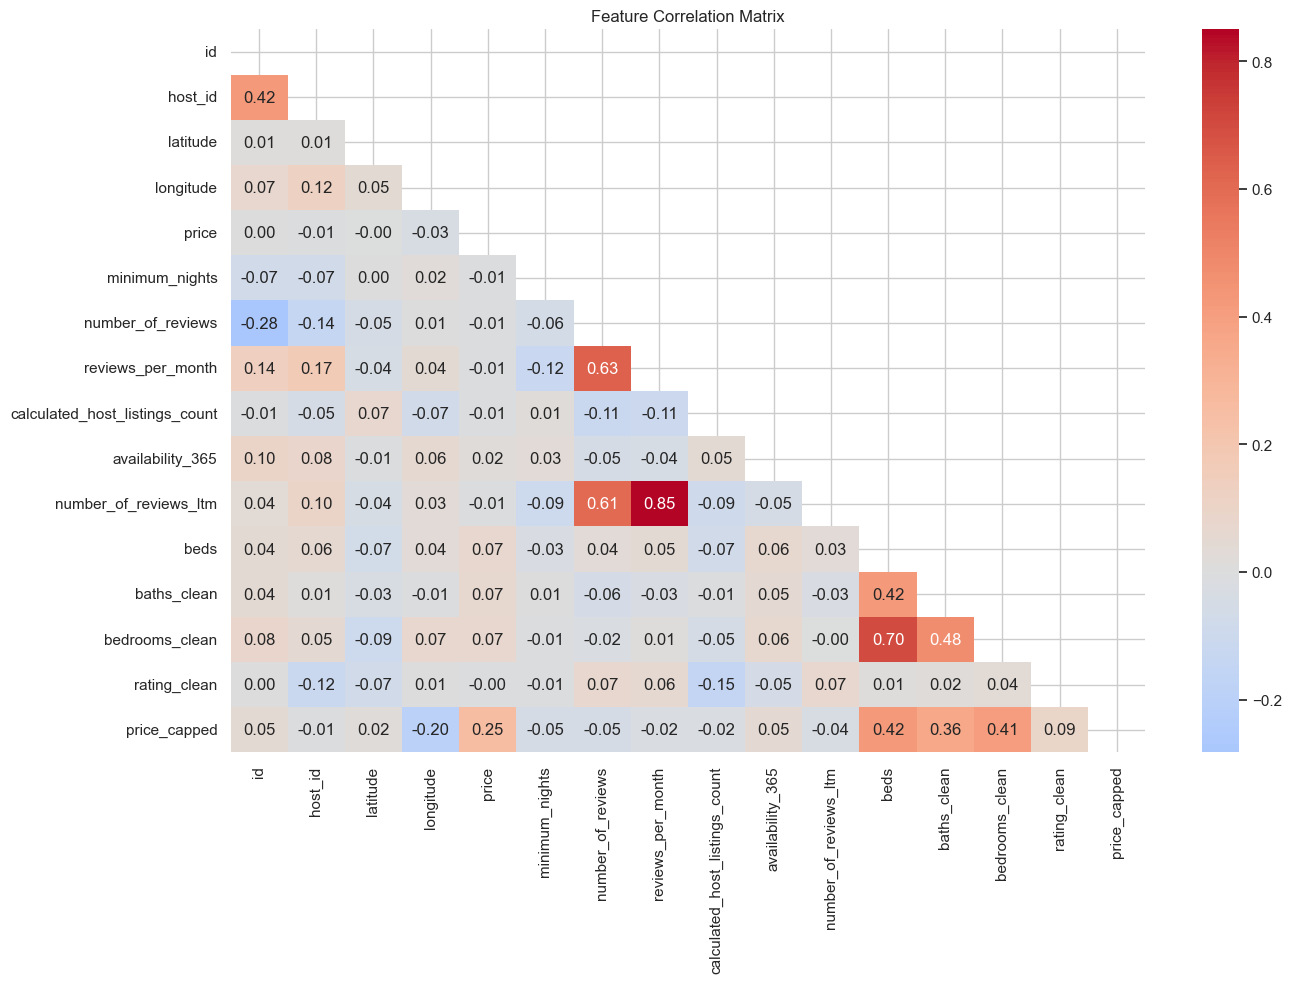

In [16]:
# Calculate correlation matrix
corr_matrix = data.select_dtypes(include=['float64', 'int64']).corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
# Mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig('outputs/correlation_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

In [17]:
# Display top correlations with price
price_correlations = corr_matrix['price'].sort_values(ascending=False)
print("Top correlations with price:")
print(price_correlations)

Top correlations with price:
price                             1.000000
price_capped                      0.253941
bedrooms_clean                    0.069298
beds                              0.066882
baths_clean                       0.066048
availability_365                  0.020151
id                                0.002372
latitude                         -0.001143
rating_clean                     -0.004692
host_id                          -0.005987
minimum_nights                   -0.006527
calculated_host_listings_count   -0.007333
reviews_per_month                -0.009917
number_of_reviews_ltm            -0.011263
number_of_reviews                -0.012588
longitude                        -0.033460
Name: price, dtype: float64


## Stadistical Analysis


STATISTICAL ANALYSIS
T-test between Manhattan and Brooklyn prices: t=20.690, p=0.0000
There is a statistically significant difference in prices between Manhattan and Brooklyn.

Chi-square test for room type distribution: chi2=884.868, p=0.0000
Room type distribution differs significantly across boroughs.


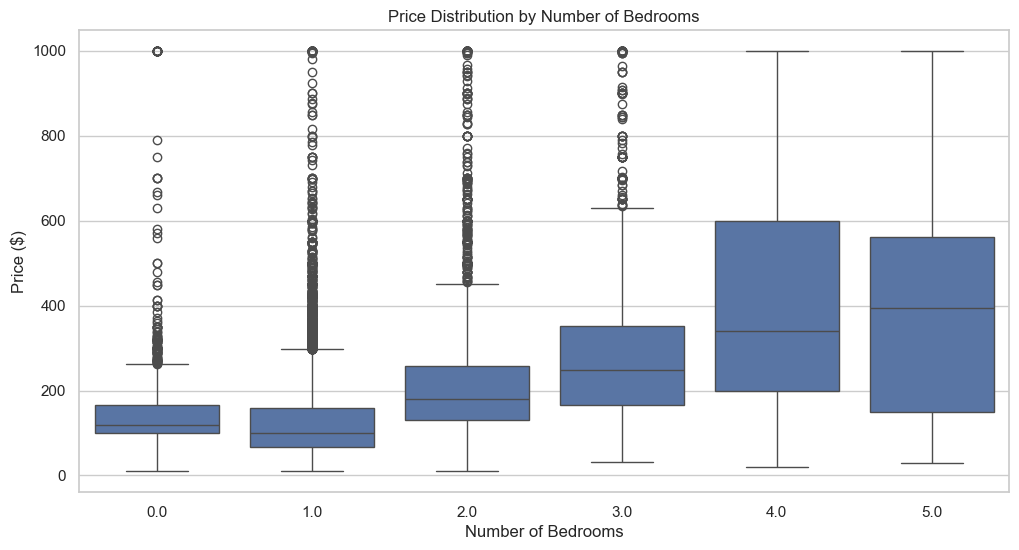

In [18]:
print("\n" + "="*50)
print("STATISTICAL ANALYSIS")
print("=".center(50, "="))

# 1. Compare prices between Manhattan and Brooklyn (t-test)
manhattan_prices = data[data['neighbourhood_group'] == 'Manhattan']['price_capped']
brooklyn_prices = data[data['neighbourhood_group'] == 'Brooklyn']['price_capped']

t_stat, p_value = ttest_ind(manhattan_prices, brooklyn_prices, equal_var=False)
print(f"T-test between Manhattan and Brooklyn prices: t={t_stat:.3f}, p={p_value:.4f}")

if p_value < 0.05:
    print("There is a statistically significant difference in prices between Manhattan and Brooklyn.")
else:
    print("There is no statistically significant difference in prices between Manhattan and Brooklyn.")

# 2. Chi-square test for room type distribution across boroughs
contingency_table = pd.crosstab(data['neighbourhood_group'], data['room_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test for room type distribution: chi2={chi2:.3f}, p={p:.4f}")

if p < 0.05:
    print("Room type distribution differs significantly across boroughs.")
else:
    print("Room type distribution is similar across boroughs.")

# 3. Analyze price distribution by number of bedrooms
plt.figure(figsize=(12, 6))
sns.boxplot(x='bedrooms_clean', y='price_capped', data=data[data['bedrooms_clean'] <= 5])
plt.title('Price Distribution by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price ($)')
plt.savefig('outputs/price_by_bedrooms.png', bbox_inches='tight', dpi=300)
plt.show()

### T-Test Results: Manhattan vs Brooklyn Prices

DETAILED PRICE COMPARISON: MANHATTAN vs BROOKLYN
Manhattan price statistics:
Mean: $208.99
Median: $150.00
Std: $184.71

Brooklyn price statistics:
Mean: $156.59
Median: $125.00
Std: $129.45

Effect size (Cohen's d): 0.329
This represents a medium effect size.


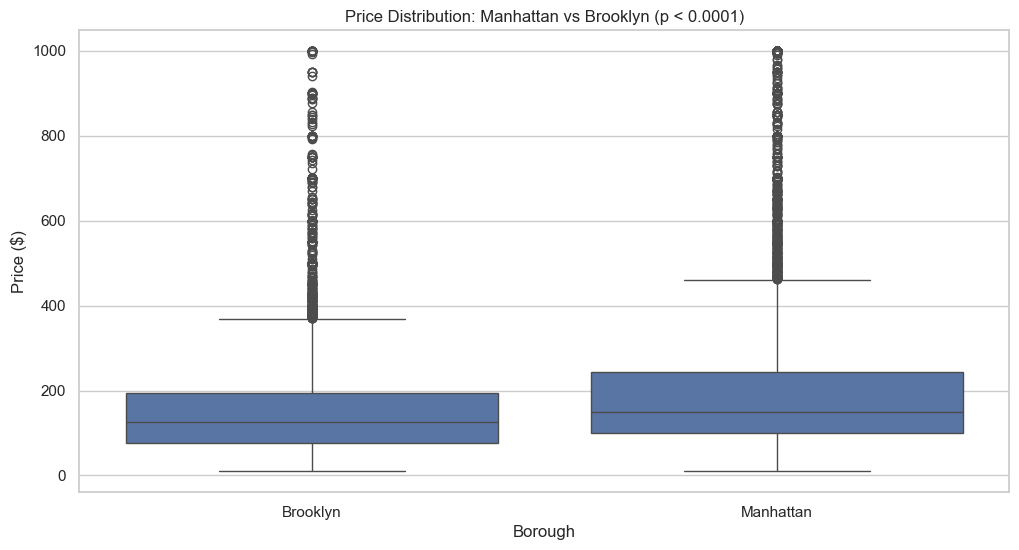

In [19]:
# Additional analysis to understand the price difference
print("=".center(50, "="))
print("DETAILED PRICE COMPARISON: MANHATTAN vs BROOKLYN")
print("=".center(50, "="))

# Calculate summary statistics
manhattan_stats = data[data['neighbourhood_group'] == 'Manhattan']['price_capped'].describe()
brooklyn_stats = data[data['neighbourhood_group'] == 'Brooklyn']['price_capped'].describe()

print("Manhattan price statistics:")
print(f"Mean: ${manhattan_stats['mean']:.2f}")
print(f"Median: ${manhattan_stats['50%']:.2f}")
print(f"Std: ${manhattan_stats['std']:.2f}")

print("\nBrooklyn price statistics:")
print(f"Mean: ${brooklyn_stats['mean']:.2f}")
print(f"Median: ${brooklyn_stats['50%']:.2f}")
print(f"Std: ${brooklyn_stats['std']:.2f}")

# Calculate effect size (Cohen's d)
mean_diff = manhattan_stats['mean'] - brooklyn_stats['mean']
pooled_std = np.sqrt((manhattan_stats['std']**2 + brooklyn_stats['std']**2) / 2)
cohens_d = mean_diff / pooled_std

print(f"\nEffect size (Cohen's d): {cohens_d:.3f}")

# Interpret effect size
if cohens_d < 0.2:
    effect_size = "small"
elif cohens_d < 0.8:
    effect_size = "medium"
else:
    effect_size = "large"

print(f"This represents a {effect_size} effect size.")

# Visualization of the price comparison
plt.figure(figsize=(12, 6))
boroughs_to_compare = ['Manhattan', 'Brooklyn']
filtered_data = data[data['neighbourhood_group'].isin(boroughs_to_compare)]

sns.boxplot(x='neighbourhood_group', y='price_capped', data=filtered_data)
plt.title('Price Distribution: Manhattan vs Brooklyn (p < 0.0001)')
plt.xlabel('Borough')
plt.ylabel('Price ($)')
plt.savefig('outputs/manhattan_brooklyn_price_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

### Chi-Square Test Results: Room Type Distribution


DETAILED ROOM TYPE ANALYSIS ACROSS BOROUGHS
Contingency Table (Counts):
room_type            Entire home/apt  Hotel room  Private room  Shared room
neighbourhood_group                                                        
Bronx                            390           0           544           15
Brooklyn                        4129           4          3464          122
Manhattan                       5288         101          2572           77
Queens                          1586           7          2093           75
Staten Island                    156           0           131            4

Contingency Table (Percentages):
room_type            Entire home/apt  Hotel room  Private room  Shared room
neighbourhood_group                                                        
Bronx                          41.10        0.00         57.32         1.58
Brooklyn                       53.49        0.05         44.88         1.58
Manhattan                      65.79        1.26         

<Figure size 1400x800 with 0 Axes>

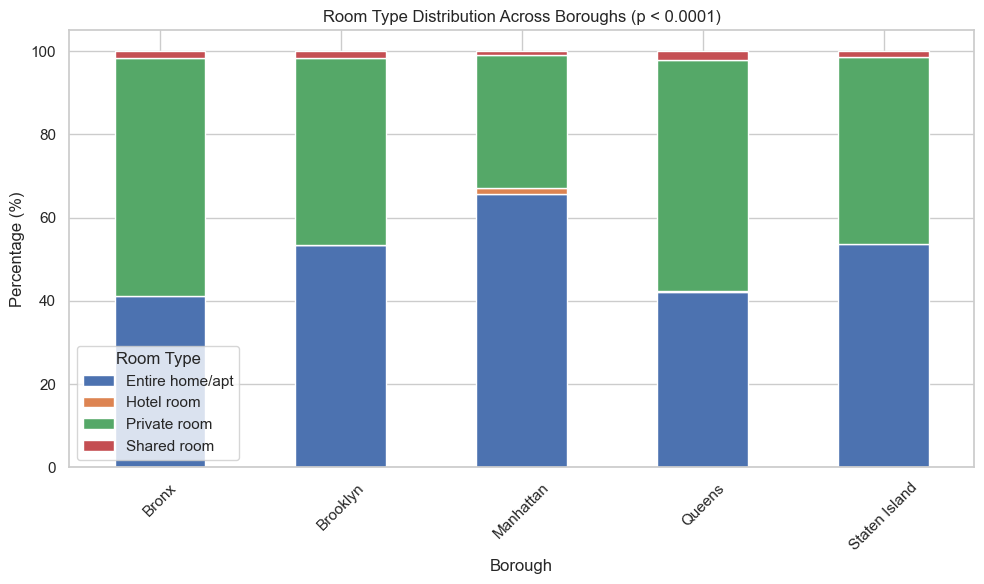

In [20]:
print("\n" + "="*50)
print("DETAILED ROOM TYPE ANALYSIS ACROSS BOROUGHS")
print("=".center(50, "="))

# Create the contingency table again for detailed analysis
contingency_table = pd.crosstab(data['neighbourhood_group'], data['room_type'])
print("Contingency Table (Counts):")
print(contingency_table)

# Calculate percentages
contingency_pct = pd.crosstab(data['neighbourhood_group'], data['room_type'], 
                              normalize='index') * 100
print("\nContingency Table (Percentages):")
print(contingency_pct.round(2))

# Calculate standardized residuals to understand which cells contribute most to chi-square
chi2, p, dof, expected = chi2_contingency(contingency_table)
residuals = (contingency_table - expected) / np.sqrt(expected)

print("\nStandardized Residuals (values > |2| indicate significant contribution):")
print(residuals.round(2))

# Visualize room type distribution across boroughs
plt.figure(figsize=(14, 8))
contingency_pct.plot(kind='bar', stacked=True)
plt.title('Room Type Distribution Across Boroughs (p < 0.0001)')
plt.xlabel('Borough')
plt.ylabel('Percentage (%)')
plt.legend(title='Room Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/room_type_distribution_by_borough.png', bbox_inches='tight', dpi=300)
plt.show()

In [21]:
# Prepare data for post-hoc analysis
room_type_data = []
for borough in data['neighbourhood_group'].unique():
    borough_subset = data[data['neighbourhood_group'] == borough]
    for room_type in borough_subset['room_type'].unique():
        count = len(borough_subset[borough_subset['room_type'] == room_type])
        room_type_data.extend([(borough, room_type)] * count)

# Convert to DataFrame for analysis
room_df = pd.DataFrame(room_type_data, columns=['borough', 'room_type'])

print("\nPost-hoc analysis for room type distribution:")
# We'll analyze each room type separately
for room_type in data['room_type'].unique():
    print(f"\nAnalysis for {room_type}:")
    room_subset = data[data['room_type'] == room_type]
    if len(room_subset) > 0:
        tukey = pairwise_tukeyhsd(room_subset['price_capped'], room_subset['neighbourhood_group'])
        print(tukey)


Post-hoc analysis for room type distribution:

Analysis for Private room:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1      group2    meandiff p-adj   lower    upper   reject
----------------------------------------------------------------
    Bronx      Brooklyn  21.4821 0.0001   8.2716  34.6926   True
    Bronx     Manhattan   63.703    0.0  50.1851  77.2209   True
    Bronx        Queens   6.6194 0.6849  -7.1659  20.4047  False
    Bronx Staten Island   11.617 0.7869  -16.261   39.495  False
 Brooklyn     Manhattan  42.2209    0.0  34.7651  49.6767   True
 Brooklyn        Queens -14.8627    0.0  -22.793  -6.9324   True
 Brooklyn Staten Island  -9.8651 0.8291  -35.361  15.6307  False
Manhattan        Queens -57.0836    0.0  -65.516 -48.6512   True
Manhattan Staten Island -52.0861    0.0 -77.7425 -26.4296   True
   Queens Staten Island   4.9975 0.9845 -20.8008  30.7959  False
----------------------------------------------------------------

Analysis for E

## Feature Engineering


FEATURE ENGINEERING
Luxury listings: 1342 (6.46%)
Active listings (reviews in last 12 months): 16148 (77.79%)


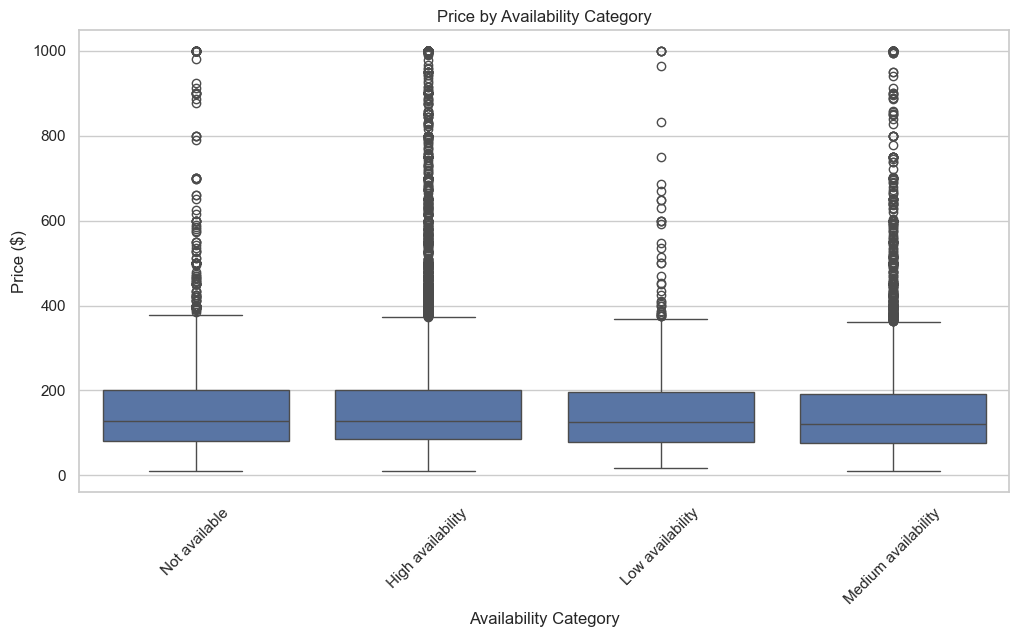

In [22]:
print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("=".center(50,"="))

# 1. Create price per bedroom feature
data['price_per_bedroom'] = data['price'] / (data['bedrooms_clean'] + 1)  # +1 to avoid division by zero

# 2. Create luxury flag based on price and amenities
price_75 = data['price'].quantile(0.75)
data['is_luxury'] = ((data['price'] > price_75) & 
                        (data['bedrooms_clean'] >= 2) & 
                        (data['baths_clean'] >= 2)).astype(int)

print(f"Luxury listings: {data['is_luxury'].sum()} ({data['is_luxury'].mean()*100:.2f}%)")

# 3. Create availability categories
def availability_category(days):
    if days == 0:
        return 'Not available'
    elif days <= 30:
        return 'Low availability'
    elif days <= 180:
        return 'Medium availability'
    else:
        return 'High availability'

data['availability_category'] = data['availability_365'].apply(availability_category)

# 4. Create review activity flag
data['is_active'] = (data['number_of_reviews_ltm'] > 0).astype(int)

print(f"Active listings (reviews in last 12 months): {data['is_active'].sum()} ({data['is_active'].mean()*100:.2f}%)")

# 5. Analyze new features
plt.figure(figsize=(12, 6))
sns.boxplot(x='availability_category', y='price_capped', data=data)
plt.title('Price by Availability Category')
plt.xlabel('Availability Category')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.savefig('outputs/price_by_availability.png', bbox_inches='tight', dpi=300)
plt.show()

In [23]:
# 1. GROUP BY operations
borough_stats = data.groupby('neighbourhood_group').agg({
    'price': ['mean', 'median', 'count'],
    'availability_365': 'mean',
    'number_of_reviews': 'sum'
}).round(2)

borough_stats.columns = ['avg_price', 'median_price', 'listing_count', 'avg_availability', 'total_reviews']
print("Borough statistics:")
borough_stats

Borough statistics:


,avg_price,median_price,listing_count,avg_availability,total_reviews
neighbourhood_group,,,,,
Bronx,118.41,89.0,949,237.59,33587
Brooklyn,187.03,125.0,7719,200.24,376779
Manhattan,227.85,150.0,8038,203.92,296907
Queens,126.49,98.0,3761,212.21,164414
Staten Island,118.78,99.0,291,232.35,13488


In [24]:
# 2. Filtering
luxury_listings = data[data['is_luxury'] == 1]
print(f"\nLuxury listings: {len(luxury_listings)}")


Luxury listings: 1342


In [25]:
# 3. Sorting
top_expensive = data.nlargest(10, 'price')[['name', 'neighbourhood_group', 'room_type', 'price']]
print("\nTop 10 most expensive listings:")
top_expensive


Top 10 most expensive listings:


,name,neighbourhood_group,room_type,price
3990,Rental unit in Brooklyn · ★4.48 · 1 bedroom · ...,Brooklyn,Private room,100000.0
5492,Rental unit in Brooklyn · ★4.33 · 1 bedroom · ...,Brooklyn,Private room,100000.0
901,Boutique hotel in New York · 1 bedroom · 1 bed...,Manhattan,Private room,10000.0
2952,Rental unit in Queens · ★4.14 · 2 bedrooms · 2...,Queens,Entire home/apt,10000.0
3026,Loft in New York · ★4.50 · 4 bedrooms · 5 beds...,Manhattan,Shared room,10000.0
3140,Boutique hotel in New York · ★3.40 · 1 bedroom...,Manhattan,Private room,10000.0
4528,Boutique hotel in New York · ★3.33 · 1 bedroom...,Manhattan,Private room,10000.0
6874,Rental unit in New York · Studio · 1 bed · 1 bath,Manhattan,Entire home/apt,10000.0
10894,Home in Bronx · ★4.30 · 1 bedroom · 1 bed · 1 ...,Bronx,Private room,9994.0
11261,Hotel in NEW YORK · ★5.0 · 1 bedroom · 1 bed ·...,Manhattan,Hotel room,7590.0


In [26]:
print("\n" + "="*50)
print("ADDITIONAL STATISTICAL ANALYSES")
print("=".center(50, "="))

# 1. ANOVA for price differences across all boroughs
borough_groups = []
for borough in data['neighbourhood_group'].unique():
    borough_groups.append(data[data['neighbourhood_group'] == borough]['price_capped'])

f_stat, p_value = f_oneway(*borough_groups)
print(f"ANOVA for price across all boroughs: F={f_stat:.3f}, p={p_value:.4f}")

# 2. Correlation between price and number of reviews
corr_price_reviews, p_value = stats.pearsonr(data['price_capped'], data['number_of_reviews'])
print(f"Correlation between price and number of reviews: r={corr_price_reviews:.3f}, p={p_value:.4f}")

# 3. Compare luxury vs non-luxury prices
luxury_prices = data[data['is_luxury'] == 1]['price_capped']
non_luxury_prices = data[data['is_luxury'] == 0]['price_capped']

t_stat, p_value = ttest_ind(luxury_prices, non_luxury_prices, equal_var=False)
print(f"T-test between luxury and non-luxury prices: t={t_stat:.3f}, p={p_value:.4f}")

# 4. Time-based analysis (if last_review_date is available)
if 'last_review_date' in data.columns:
    data['review_year'] = data['last_review_date'].dt.year
    recent_reviews = data[data['review_year'] >= 2023]
    print(f"\nListings with recent reviews (2023+): {len(recent_reviews)}")
    
    # Compare prices of recently reviewed vs older listings
    recent_prices = recent_reviews['price_capped']
    older_prices = data[data['review_year'] < 2023]['price_capped']
    
    t_stat, p_value = ttest_ind(recent_prices, older_prices, equal_var=False)
    print(f"T-test between recently reviewed and older listings: t={t_stat:.3f}, p={p_value:.4f}")


ADDITIONAL STATISTICAL ANALYSES
ANOVA for price across all boroughs: F=303.050, p=0.0000
Correlation between price and number of reviews: r=-0.046, p=0.0000
T-test between luxury and non-luxury prices: t=47.022, p=0.0000


## Outlier Detection

In [27]:
print("\n" + "="*50)
print("OUTLIER DETECTION")
print("=".center(50, "="))

# Identify listings with extreme prices
high_price_listings = data[data['price'] > 1000]
print(f"Listings with price > $1000: {len(high_price_listings)}")
print(high_price_listings[['neighbourhood_group', 'room_type', 'price', 'bedrooms_clean', 'beds']].describe())

# Z-score method for outlier detection
data['price_zscore'] = np.abs(stats.zscore(data['price_capped']))
price_outliers = data[data['price_zscore'] > 3]
print(f"\nPrice outliers (Z-score > 3): {len(price_outliers)}")

# IQR method for outlier detection
Q1 = data['price_capped'].quantile(0.25)
Q3 = data['price_capped'].quantile(0.75)
IQR = Q3 - Q1
price_outliers_iqr = data[(data['price_capped'] < (Q1 - 1.5 * IQR)) | (data['price_capped'] > (Q3 + 1.5 * IQR))]
print(f"Price outliers (IQR method): {len(price_outliers_iqr)}")


OUTLIER DETECTION
Listings with price > $1000: 168
               price  bedrooms_clean        beds
count     168.000000      168.000000  168.000000
mean     3437.863095        2.732143    3.732143
std     10824.293758        2.156936    4.131771
min      1002.000000        0.000000    1.000000
25%      1200.000000        1.000000    2.000000
50%      1500.000000        2.000000    3.000000
75%      2375.250000        3.250000    4.000000
max    100000.000000       15.000000   42.000000

Price outliers (Z-score > 3): 509
Price outliers (IQR method): 1385


In [28]:
print("Project completed successfully!")
print(f"Generated {len([f for f in os.listdir('outputs') if f.endswith('.png')])} visualizations")
print(f"Dataset shape: {data.shape}")
print(f"Columns analyzed: {len(data.columns)}")

# Save the cleaned and enhanced dataset
data.to_csv('data/airbnb_nyc_cleaned.csv', index=False)
print("Cleaned dataset saved to data/airbnb_nyc_cleaned.csv")

Project completed successfully!
Generated 14 visualizations
Dataset shape: (20758, 31)
Columns analyzed: 31
Cleaned dataset saved to data/airbnb_nyc_cleaned.csv
